Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import datetime as dt
import matplotlib.ticker as mticker
import geopandas as gpd
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
import calendar
# import h5py
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim, ALL_TIMES, extract_times, g_times,
                 interpline, CoordPair, xy_to_ll, ll_to_xy, vertcross)
from shapely.geometry.polygon import Polygon
import wrf
import scipy.stats as sps
import matplotlib as mpl
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors

Read files

In [3]:
wrf_path_base = '/gws/nopw/j04/klingaman/baracoma/WRF/out/runs/'
path_out = '/home/users/baracoma/notebooks/wrf_expts/paper2/'

lf_list = pd.read_csv(os.path.join('/home/users/baracoma/notebooks/wrf_expts/2021-05-11', 'lf_list_processing.csv'))
lf_list['DateStr'] = lf_list['LF Year'].apply(str) + lf_list['LF Month'].apply(str).str.zfill(2) + lf_list['LF Date'].apply(str).str.zfill(2) + lf_list['LF Hour'].apply(str).str.zfill(2)
tc_incl = ['KOPPU', 'NESAT', 'MEGI', 'IMBUDO', 'CIMARON', 'BEBINCA', 'NARI', 'PRAPIROON']
# tc_incl = ['KOPPU', 'BEBINCA', 'NARI', 'CIMARON']
lf_list = lf_list[lf_list.NAME.isin(tc_incl)]
lf_list['DateStr'] = pd.to_datetime(lf_list['DateStr'], format="%Y%m%d%H")
lf_list = lf_list.set_index('NAME')
exptnames = {'orig': 'Control', 'enha':'Enhanced Topography', 'redu': 'Reduced Topography'}
lf_tracks = pd.read_pickle('lf_list_adjusted.pkl')

crs = ccrs.PlateCarree()

In [4]:
def get_mslp(ds, i):
    """Gets ds from slice i and then calculates MSLP"""
    stemps = ds.T2[i]+6.5*ds.HGT[i]/1000.
    mslp = ds.PSFC[i]*np.exp(9.81/(287.0*stemps)*ds.HGT[i])*0.01 +(6.7 * ds.HGT[i] / 1000.)
    return mslp

Sample dataset for extraction of coordinates

In [16]:
# get sample for coords
tcname = 'KOPPU'
tc_ts = lf_list.loc[tcname].o_ts
expt='orig'

# get wrf out path
tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+expt)
tc_list = os.listdir(tc_path)
for wrf_ncs in tc_list:
    if wrf_ncs[0:10]=='wrfout_d02':
        wrf_nc = wrf_ncs
tc_nc_path = os.path.join(tc_path, wrf_nc)
ncfile = Dataset(tc_nc_path)
uv10 = getvar(ncfile, "uvmet10", units="kt", timeidx=tc_ts)
hgt_m = getvar(ncfile, "ter", timeidx=tc_ts)

# get xlong and xlat arrays
xlong_c = uv10.XLONG.values[:,:]
xlat_c = uv10.XLAT.values[:,:]
lats, lons = latlon_coords(uv10)

Get mountain boundaries

In [8]:
lat_min = 13
lat_max = 19
lon_min = 118
lon_max = 125

# Plains
q1_lat_max = 18.4
q1_lat_min = q1_lat_max-0.7
q1_lon_max = 121.35
q1_lon_min = q1_lon_max-.25

q2_lat_max = q1_lat_min
q2_lat_min = q2_lat_max-0.7
q2_lon_max = 121.5
q2_lon_min = q2_lon_max-.25

q3_lat_max = q2_lat_min
q3_lat_min = q3_lat_max-0.7
q3_lon_max = 121.35
q3_lon_min = q3_lon_max-.25

# Slope
q1_lat_max_mnt = q1_lat_max
q1_lat_min_mnt = q1_lat_min
q1_lon_max_mnt = q1_lon_max-.25
q1_lon_min_mnt = q1_lon_min-.25

q2_lat_max_mnt = q2_lat_max
q2_lat_min_mnt = q2_lat_min
q2_lon_max_mnt = q2_lon_max-.25
q2_lon_min_mnt = q2_lon_min-.25

q3_lat_max_mnt = q3_lat_max
q3_lat_min_mnt = q3_lat_min
q3_lon_max_mnt = q3_lon_max-.25
q3_lon_min_mnt = q3_lon_min-.25

Set boundaries

In [10]:
# Plains
q1_conds = (xlong_c >= q1_lon_min) & (xlong_c <= q1_lon_max) & (xlat_c >= q1_lat_min) & (xlat_c <= q1_lat_max)
q1_conds_lon = (xlong_c >= q1_lon_min) & (xlong_c <= q1_lon_max)
q1_conds_lat = (xlat_c >= q1_lat_min) & (xlat_c <= q1_lat_max)

q2_conds = (xlong_c >= q2_lon_min) & (xlong_c <= q2_lon_max) & (xlat_c >= q2_lat_min) & (xlat_c <= q2_lat_max)
q2_conds_lon = (xlong_c >= q2_lon_min) & (xlong_c <= q2_lon_max)
q2_conds_lat = (xlat_c >= q2_lat_min) & (xlat_c <= q2_lat_max)

q3_conds = (xlong_c >= q3_lon_min) & (xlong_c <= q3_lon_max) & (xlat_c >= q3_lat_min) & (xlat_c <= q3_lat_max)
q3_conds_lon = (xlong_c >= q3_lon_min) & (xlong_c <= q3_lon_max)
q3_conds_lat = (xlat_c >= q3_lat_min) & (xlat_c <= q3_lat_max)

q1_up_lim = np.where(q1_conds == True)[0][0]
q1_down_lim = np.where(q1_conds == True)[0][-1]
q1_left_lim = np.where(q1_conds == True)[1][0]
q1_right_lim = np.where(q1_conds == True)[1][-1]

q2_up_lim = np.where(q2_conds == True)[0][0]
q2_down_lim = np.where(q2_conds == True)[0][-1]
q2_left_lim = np.where(q2_conds == True)[1][0]
q2_right_lim = np.where(q2_conds == True)[1][-1]

q3_up_lim = np.where(q3_conds == True)[0][0]
q3_down_lim = np.where(q3_conds == True)[0][-1]
q3_left_lim = np.where(q3_conds == True)[1][0]
q3_right_lim = np.where(q3_conds == True)[1][-1]

# Slope
q1_conds_mnt = (xlong_c >= q1_lon_min_mnt) & (xlong_c <= q1_lon_max_mnt) & (xlat_c >= q1_lat_min_mnt) & (xlat_c <= q1_lat_max_mnt)
q1_conds_lon_mnt = (xlong_c >= q1_lat_min_mnt) & (xlong_c <= q1_lon_max_mnt)
q1_conds_lat_mnt = (xlat_c >= q1_lat_min_mnt) & (xlat_c <= q1_lat_max_mnt)

q2_conds_mnt = (xlong_c >= q2_lon_min_mnt) & (xlong_c <= q2_lon_max_mnt) & (xlat_c >= q2_lat_min_mnt) & (xlat_c <= q2_lat_max)
q2_conds_lon_mnt = (xlong_c >= q2_lon_min_mnt) & (xlong_c <= q2_lon_max_mnt)
q2_conds_lat_mnt = (xlat_c >= q2_lon_min_mnt) & (xlat_c <= q2_lat_max)

q3_conds_mnt = (xlong_c >= q3_lon_min_mnt) & (xlong_c <= q3_lon_max_mnt) & (xlat_c >= q3_lat_min_mnt) & (xlat_c <= q3_lat_max_mnt)
q3_conds_lon_mnt = (xlong_c >= q3_lon_min_mnt) & (xlong_c <= q3_lon_max_mnt)
q3_conds_lat_mnt = (xlat_c >= q3_lat_min_mnt) & (xlat_c <= q3_lat_max_mnt)

q1_up_lim_mnt = np.where(q1_conds_mnt == True)[0][0]
q1_down_lim_mnt = np.where(q1_conds_mnt == True)[0][-1]
q1_left_lim_mnt = np.where(q1_conds_mnt == True)[1][0]
q1_right_lim_mnt = np.where(q1_conds_mnt == True)[1][-1]

q2_up_lim_mnt = np.where(q2_conds_mnt == True)[0][0]
q2_down_lim_mnt = np.where(q2_conds_mnt == True)[0][-1]
q2_left_lim_mnt = np.where(q2_conds_mnt == True)[1][0]
q2_right_lim_mnt = np.where(q2_conds_mnt == True)[1][-1]

q3_up_lim_mnt = np.where(q3_conds_mnt == True)[0][0]
q3_down_lim_mnt = np.where(q3_conds_mnt == True)[0][-1]
q3_left_lim_mnt = np.where(q3_conds_mnt == True)[1][0]
q3_right_lim_mnt = np.where(q3_conds_mnt == True)[1][-1]



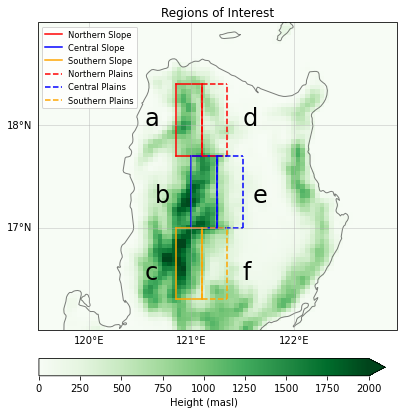

In [17]:
fig = plt.figure(figsize=(10,6.5),
                          facecolor='white')   

ax1 = fig.add_subplot(111, facecolor='None', projection=crs)
ax1.coastlines(resolution='10m', alpha=0.5)
gl = ax1.gridlines(crs=crs, draw_labels=True, alpha=0.5)
gl.top_labels = None
gl.right_labels = None
xgrid = np.arange(lon_min-10, lon_max+10, 1)
ygrid = np.arange(lat_min-10, lat_max+10, 1)
gl.xlocator = mticker.FixedLocator(xgrid.tolist())
gl.ylocator = mticker.FixedLocator(ygrid.tolist())
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'black'}
gl.ylabel_style = {'size': 10, 'color': 'black'}

plot_hgt = ax1.pcolormesh(lons, lats, hgt_m, cmap='Greens', vmin=0, vmax=2000)

# mnt
ax1.plot([q1_lon_min_mnt,q1_lon_max_mnt], [q1_lat_max_mnt, q1_lat_max_mnt], transform=crs, color='red', label='Northern Slope')
ax1.plot([q1_lon_min_mnt,q1_lon_max_mnt], [q1_lat_min_mnt, q1_lat_min_mnt], transform=crs, color='red')
ax1.plot([q1_lon_min_mnt,q1_lon_min_mnt], [q1_lat_min_mnt, q1_lat_max_mnt], transform=crs, color='red')
ax1.plot([q1_lon_max_mnt,q1_lon_max_mnt], [q1_lat_min_mnt, q1_lat_max_mnt], transform=crs, color='red')

ax1.plot([q2_lon_min_mnt,q2_lon_max_mnt], [q2_lat_max_mnt, q2_lat_max_mnt], transform=crs, color='blue', label='Central Slope')
ax1.plot([q2_lon_min_mnt,q2_lon_max_mnt], [q2_lat_min_mnt, q2_lat_min_mnt], transform=crs, color='blue')
ax1.plot([q2_lon_min_mnt,q2_lon_min_mnt], [q2_lat_min_mnt, q2_lat_max_mnt], transform=crs, color='blue')
ax1.plot([q2_lon_max_mnt,q2_lon_max_mnt], [q2_lat_min_mnt, q2_lat_max_mnt], transform=crs, color='blue')

ax1.plot([q3_lon_min_mnt,q3_lon_max_mnt], [q3_lat_max_mnt, q3_lat_max_mnt], transform=crs, color='orange', label='Southern Slope')
ax1.plot([q3_lon_min_mnt,q3_lon_max_mnt], [q3_lat_min_mnt, q3_lat_min_mnt], transform=crs, color='orange')
ax1.plot([q3_lon_min_mnt,q3_lon_min_mnt], [q3_lat_min_mnt, q3_lat_max_mnt], transform=crs, color='orange')
ax1.plot([q3_lon_max_mnt,q3_lon_max_mnt], [q3_lat_min_mnt, q3_lat_max_mnt], transform=crs, color='orange')

# app
ax1.plot([q1_lon_min,q1_lon_max], [q1_lat_max, q1_lat_max], transform=crs, color='red', linestyle='--', label='Northern Plains')
ax1.plot([q1_lon_min,q1_lon_max], [q1_lat_min, q1_lat_min], transform=crs, color='red', linestyle='--')
ax1.plot([q1_lon_min,q1_lon_min], [q1_lat_min, q1_lat_max], transform=crs, color='red', linestyle='--')
ax1.plot([q1_lon_max,q1_lon_max], [q1_lat_min, q1_lat_max], transform=crs, color='red', linestyle='--')

ax1.plot([q2_lon_min,q2_lon_max], [q2_lat_max, q2_lat_max], transform=crs, color='blue', linestyle='--', label='Central Plains')
ax1.plot([q2_lon_min,q2_lon_max], [q2_lat_min, q2_lat_min], transform=crs, color='blue', linestyle='--')
ax1.plot([q2_lon_min,q2_lon_min], [q2_lat_min, q2_lat_max], transform=crs, color='blue', linestyle='--')
ax1.plot([q2_lon_max,q2_lon_max], [q2_lat_min, q2_lat_max], transform=crs, color='blue', linestyle='--')

ax1.plot([q3_lon_min,q3_lon_max], [q3_lat_max, q3_lat_max], transform=crs, color='orange', linestyle='--', label='Southern Plains')
ax1.plot([q3_lon_min,q3_lon_max], [q3_lat_min, q3_lat_min], transform=crs, color='orange', linestyle='--')
ax1.plot([q3_lon_min,q3_lon_min], [q3_lat_min, q3_lat_max], transform=crs, color='orange', linestyle='--')
ax1.plot([q3_lon_max,q3_lon_max], [q3_lat_min, q3_lat_max], transform=crs, color='orange', linestyle='--')

cbar_ter = fig.colorbar(plot_hgt, ax=ax1, orientation='horizontal', fraction=0.049, pad=0.08, extend='max')
cbar_ter.set_label('Height (masl)')

ax1.text(120.54, 18, 'a', fontsize=24)
ax1.text(120.64, 17.25, 'b', fontsize=24)
ax1.text(120.54, 16.5, 'c', fontsize=24)

ax1.text(121.50, 18, 'd', fontsize=24)
ax1.text(121.60, 17.25, 'e', fontsize=24)
ax1.text(121.50, 16.5, 'f', fontsize=24)

ax1.set_xlim((119.5, 123))
ax1.set_ylim((16, 19))
plt.title('Regions of Interest', fontsize='large')
plt.legend(loc='upper left', fontsize='small')
# plt.savefig(os.path.join(path_out, 'regions_of_interest.png'), bbox_inches='tight', dpi=300)
plt.show()

Define dataframe, and populate with calculations

In [24]:
df = pd.DataFrame(columns=['time', 
                           'tcname',
                           'expt',
                           'u_1',
                           'u_2',
                           'u_3',
                           'u_1_mnt',
                           'u_2_mnt',
                           'u_3_mnt',
                           'wa_1_mnt',
                           'wa_2_mnt',
                           'wa_3_mnt',                             
                           'u10_1',
                           'u10_2',
                           'u10_3',
                           'u10_1_mnt',
                           'u10_2_mnt',
                           'u10_3_mnt',                           
                           'Fw_1',
                           'Fw_2',
                           'Fw_3',
                           'rr_1',
                           'rr_2',
                           'rr_3',
                           'rl_1',
                           'rl_2',
                           'rl_3',                           
                           'h_1',
                           'h_2',
                           'h_3',
                           'dydx_1',
                           'dydx_2',
                           'dydx_3',                           
                           'nw_1',
                           'nw_2',
                           'nw_3',
                           'lfhr',
                           'mslp'
                           'tcint'                           
                           'tclat',
                           'tclon'
                          ])

dx = 277.75*1000
k=-1

for expt in list(exptnames):
    for tcname in list(lf_list.index.values):
        print(tcname+': '+expt)    
        tc_path = os.path.join(wrf_path_base,tcname.lower()+'_'+expt)
        tc_list = os.listdir(tc_path)
        for wrf_ncs in tc_list:
            if wrf_ncs[0:10]=='wrfout_d02':
                wrf_nc = wrf_ncs
        tc_nc_path = os.path.join(tc_path, wrf_nc)

        ncfile = Dataset(tc_nc_path)
        
        for j in range(16):            
            try:
                k+=1
                if expt=='orig':
                    tc_ts = lf_list.loc[tcname].o_ts-8+j
                    mslp_lat = lf_tracks.loc[tcname].orig_t[1][tc_ts]
                    mslp_lon = lf_tracks.loc[tcname].orig_t[0][tc_ts]                
                elif expt=='enha':
                    tc_ts = lf_list.loc[tcname].e_ts-8+j
                    mslp_lat = lf_tracks.loc[tcname].enha_t[1][tc_ts]
                    mslp_lon = lf_tracks.loc[tcname].enha_t[0][tc_ts]                
                elif expt=='redu':
                    tc_ts = lf_list.loc[tcname].r_ts-8+j
                    mslp_lat = lf_tracks.loc[tcname].redu_t[1][tc_ts]
                    mslp_lon = lf_tracks.loc[tcname].redu_t[0][tc_ts]                

                lfhr = 3*(8-j)
                lvl = 8

                hgt_m = getvar(ncfile, "ter", timeidx=tc_ts)
                ua_1km = getvar(ncfile, "ua", units="m s-1", timeidx=tc_ts)[lvl]
                va_1km = getvar(ncfile, "va", units="m s-1", timeidx=tc_ts)[lvl]
                wa_1km = getvar(ncfile, "wa", units="m s-1", timeidx=tc_ts)[lvl]            
                u10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=tc_ts)[0]
                v10 = getvar(ncfile, "uvmet10", units="m s-1", timeidx=tc_ts)[1]
                uv10 = np.sqrt(u10**2+v10**2)
                # rainnc_inst = ncfile['RAINNC'][tc_ts] - ncfile['RAINNC'][tc_ts-1]
                rainnc_inst = (getvar(ncfile, "RAINNC",timeidx=tc_ts)+getvar(ncfile, "RAINC",timeidx=tc_ts)) - (getvar(ncfile, "RAINNC",timeidx=tc_ts-1)+getvar(ncfile, "RAINC",timeidx=tc_ts-1))

                ph = getvar(ncfile, 'PH', timeidx=tc_ts)
                phb = getvar(ncfile, 'PHB', timeidx=tc_ts)

                qcloud = getvar(ncfile, 'QCLOUD',timeidx=tc_ts)
                q = getvar(ncfile, 'QVAPOR',timeidx=tc_ts)    
                t = getvar(ncfile, 'tc', timeidx=tc_ts)
                p = getvar(ncfile,'p', timeidx=tc_ts, units='hPa')
                th = getvar(ncfile, 'th', timeidx=tc_ts, units='degC')

                # for grabbing mslp
                hgt = getvar(ncfile,"HGT", timeidx=tc_ts)
                stemps = getvar(ncfile, "T2", timeidx=tc_ts) + 6.5*hgt/1000.
                mslp = getvar(ncfile, "PSFC", timeidx=tc_ts)*np.exp(9.81/(287.0*stemps)*hgt)*0.01+(6.7 * hgt/1000.)



                ll_x = ll_to_xy(ncfile, mslp_lat, mslp_lon).values[0]
                ll_y = ll_to_xy(ncfile, mslp_lat, mslp_lon).values[1]

                mslp_tc = np.min(mslp[ll_y-20:ll_y+20,ll_x-20:ll_x+20])
                tcint = np.max(uv10[ll_y-20:ll_y+20,ll_x-20:ll_x+20])    


                h_1_mnt_crop = hgt_m[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
                h_2_mnt_crop = hgt_m[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]
                h_3_mnt_crop = hgt_m[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]

                mean_top = np.mean(h_1_mnt_crop).values
                mean_mid = np.mean(h_2_mnt_crop).values
                mean_bot = np.mean(h_3_mnt_crop).values

                u_crop_1_mnt_1km = ua_1km[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
                u_crop_2_mnt_1km = ua_1km[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]
                u_crop_3_mnt_1km = ua_1km[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]

                w_crop_1_mnt_1km = wa_1km[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
                w_crop_2_mnt_1km = wa_1km[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]
                w_crop_3_mnt_1km = wa_1km[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]            

                v_crop_1_mnt_1km = va_1km[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
                v_crop_2_mnt_1km = va_1km[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]
                v_crop_3_mnt_1km = va_1km[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]            

                u_crop_1_mnt_10m = u10[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]
                u_crop_2_mnt_10m = u10[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]
                u_crop_3_mnt_10m = u10[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]

                u_crop_1_app_1km = ua_1km[q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                u_crop_2_app_1km = ua_1km[q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                u_crop_3_app_1km = ua_1km[q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]

                u_crop_1_app_10m = u10[q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                u_crop_2_app_10m = u10[q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                u_crop_3_app_10m = u10[q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]


                th_crop_1_app = th[:lvl, q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                th_crop_2_app = th[:lvl, q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                th_crop_3_app = th[:lvl, q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]

                t_crop_1_app = t[:lvl, q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                t_crop_2_app = t[:lvl, q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                t_crop_3_app = t[:lvl, q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]

                qcloud_crop_1_app = qcloud[:lvl, q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                qcloud_crop_2_app = qcloud[:lvl, q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                qcloud_crop_3_app = qcloud[:lvl, q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]

                q_crop_1_app = q[:lvl, q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                q_crop_2_app = q[:lvl, q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                q_crop_3_app = q[:lvl, q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]

                p_crop_1_app = p[:lvl, q1_up_lim:q1_down_lim, q1_left_lim:q1_right_lim]
                p_crop_2_app = p[:lvl, q2_up_lim:q2_down_lim, q2_left_lim:q2_right_lim]
                p_crop_3_app = p[:lvl, q3_up_lim:q3_down_lim, q3_left_lim:q3_right_lim]      

                rr_crop_1 = rainnc_inst[q1_up_lim_mnt:q1_down_lim_mnt, q1_left_lim_mnt:q1_right_lim_mnt]/3.
                rr_crop_2 = rainnc_inst[q2_up_lim_mnt:q2_down_lim_mnt, q2_left_lim_mnt:q2_right_lim_mnt]/3.
                rr_crop_3 = rainnc_inst[q3_up_lim_mnt:q3_down_lim_mnt, q3_left_lim_mnt:q3_right_lim_mnt]/3.    

                # rl_crop_1 = rainnc_inst[q1_up_lim_lee:q1_down_lim_lee, q1_left_lim_lee:q1_right_lim_lee]/3.
                # rl_crop_2 = rainnc_inst[q2_up_lim_lee:q2_down_lim_lee, q2_left_lim_lee:q2_right_lim_lee]/3.
                # rl_crop_3 = rainnc_inst[q3_up_lim_lee:q3_down_lim_lee, q3_left_lim_lee:q3_right_lim_lee]/3.        



                es_crop_1 = 6.112*np.exp(17.67*t_crop_1_app/(t_crop_1_app+243.5))
                ws_1 = (0.622*es_crop_1)/(p_crop_1_app-es_crop_1)

            #     r_crop_1 = th_crop_1_app*(1+0.61*ws_1)
            #     r_crop_1 = th_crop_1_app*(1+0.61*ws_1-qcloud_crop_1_app)    
                r_crop_1 = th_crop_1_app*(1+0.61*q_crop_1_app)
                r_crop_1_all = []
                lvl_hgt_1 = []
                for i in range(lvl):
                    r_crop_1_all.append(float(r_crop_1[i].mean().values))
                    lvl_hgt_1.append(np.mean((ph[i].values+phb[i].values)*(1/9.8)-hgt_m.values))
                #     print(r_crop_1[i].mean().values)
                dthdz = np.mean((np.array(r_crop_1_all[1:])-np.array(r_crop_1_all[:-1]))/(np.array(lvl_hgt_1[1:])-np.array(lvl_hgt_1[:-1])))
            #     nw_crop_1 = np.sqrt((9.8/np.mean(r_crop_1[:]))*((r_crop_1_all[-1]-r_crop_1_all[0])/1000.))
                nw_crop_1 = np.sqrt((9.8/np.mean(r_crop_1[:]))*(dthdz))
                Fw_1 = ((np.mean(u_crop_1_app_1km))/(nw_crop_1*np.mean(h_1_mnt_crop)))                

                es_crop_2 = 6.112*np.exp(17.67*t_crop_2_app/(t_crop_2_app+243.5))
                ws_2 = (0.622*es_crop_2)/(p_crop_2_app-es_crop_2)

                r_crop_2 = th_crop_2_app*(1+0.61*q_crop_2_app)
                r_crop_2_all = []
                lvl_hgt_2 = []    
                for i in range(lvl):
                    r_crop_2_all.append(float(r_crop_2[i].mean().values))
                nw_crop_2 = np.sqrt((9.8/np.mean(r_crop_2[:]))*(dthdz))            
                Fw_2 = ((np.mean(u_crop_2_app_1km))/(nw_crop_2*np.mean(h_2_mnt_crop)))                

                es_crop_3 = 6.112*np.exp(17.67*t_crop_3_app/(t_crop_3_app+243.5))
                ws_3 = (0.622*es_crop_3)/(p_crop_3_app-es_crop_3)

                r_crop_3 = th_crop_3_app*(1+0.61*q_crop_3_app)
                r_crop_3_all = []
                lvl_hgt_3 = []    
                for i in range(lvl):
                    r_crop_3_all.append(float(r_crop_3[i].mean().values))
                nw_crop_3 = np.sqrt((9.8/np.mean(r_crop_3[:]))*(dthdz))
                Fw_3 = ((np.mean(u_crop_3_app_1km))/(nw_crop_3*np.mean(h_3_mnt_crop)))                

                df.loc[k, 'time'] = pd.Timestamp(ua_1km.Time.values).to_pydatetime()

                df.loc[k, 'tcname'] = tcname
                df.loc[k, 'expt'] = expt
                df.loc[k, 'u_1'] = np.nanmean(u_crop_1_app_1km)    
                df.loc[k, 'u_2'] = np.nanmean(u_crop_2_app_1km)
                df.loc[k, 'u_3'] = np.nanmean(u_crop_3_app_1km)
                df.loc[k, 'u_1_mnt'] = np.nanmean(u_crop_1_mnt_1km)    
                df.loc[k, 'u_2_mnt'] = np.nanmean(u_crop_2_mnt_1km)
                df.loc[k, 'u_3_mnt'] = np.nanmean(u_crop_3_mnt_1km)     
                df.loc[k, 'v_1_mnt'] = np.nanmean(v_crop_1_mnt_1km)    
                df.loc[k, 'v_2_mnt'] = np.nanmean(v_crop_2_mnt_1km)
                df.loc[k, 'v_3_mnt'] = np.nanmean(v_crop_3_mnt_1km)
                df.loc[k, 'w_1_mnt'] = np.nanmean(w_crop_1_mnt_1km)    
                df.loc[k, 'w_2_mnt'] = np.nanmean(w_crop_2_mnt_1km)
                df.loc[k, 'w_3_mnt'] = np.nanmean(w_crop_3_mnt_1km)               
                df.loc[k, 'u10_1'] = np.nanmean(u_crop_1_app_10m)    
                df.loc[k, 'u10_2'] = np.nanmean(u_crop_2_app_10m)
                df.loc[k, 'u10_3'] = np.nanmean(u_crop_3_app_10m)
                df.loc[k, 'u10_1_mnt'] = np.nanmean(u_crop_1_mnt_10m)    
                df.loc[k, 'u10_2_mnt'] = np.nanmean(u_crop_2_mnt_10m)
                df.loc[k, 'u10_3_mnt'] = np.nanmean(u_crop_3_mnt_10m)                    
                df.loc[k, 'Fw_1'] = float(Fw_1)
                df.loc[k, 'Fw_2'] = float(Fw_2)
                df.loc[k, 'Fw_3'] = float(Fw_3)
                df.loc[k, 'rr_1'] = np.nanmean(rr_crop_1)
                df.loc[k, 'rr_2'] = np.nanmean(rr_crop_2)    
                df.loc[k, 'rr_3'] = np.nanmean(rr_crop_3)                  
                df.loc[k, 'h_1'] = np.nanmean(h_1_mnt_crop)
                df.loc[k, 'h_2'] = np.nanmean(h_2_mnt_crop) 
                df.loc[k, 'h_3'] = np.nanmean(h_3_mnt_crop) 
                df.loc[k, 'dydx_1'] = np.nanmean(h_1_mnt_crop)/dx
                df.loc[k, 'dydx_2'] = np.nanmean(h_2_mnt_crop)/dx 
                df.loc[k, 'dydx_3'] = np.nanmean(h_3_mnt_crop)/dx                        
                df.loc[k, 'nw_1'] = np.nanmean(nw_crop_1)    
                df.loc[k, 'nw_2'] = np.nanmean(nw_crop_1)    
                df.loc[k, 'nw_3'] = np.nanmean(nw_crop_3)     
                df.loc[k, 'lfhr'] = lfhr 
                df.loc[k, 'mslp'] = float(mslp_tc)
                df.loc[k, 'tclat'] = mslp_lat
                df.loc[k, 'tclon'] = mslp_lon
                df.loc[k, 'tcint'] = float(tcint)
            except Exception as e :
                print(e)

print('Saving to: '+os.path.join(path_out, 'wrf_calc.pkl'))
df.to_pickle(os.path.join(path_out, 'wrf_calc.pkl'))

MEGI: orig
IMBUDO: orig


/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/tmp/ipykernel_742/2177432419.py:253: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_1'] = np.nanmean(nw_crop_1)
/tmp/ipykernel_742/2177432419.py:254: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_2'] = np.nanmean(nw_crop_1)
/tmp/ipykernel_742/2177432419.py:255: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_3'] = np.nanmean(nw_crop_3)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py

CIMARON: orig
BEBINCA: orig
KOPPU: orig
NESAT: orig
NARI: orig
PRAPIROON: orig
MEGI: enha
IMBUDO: enha
CIMARON: enha
BEBINCA: enha
KOPPU: enha
NESAT: enha
NARI: enha
PRAPIROON: enha
MEGI: redu
IMBUDO: redu


/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/tmp/ipykernel_742/2177432419.py:253: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_1'] = np.nanmean(nw_crop_1)
/tmp/ipykernel_742/2177432419.py:254: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_2'] = np.nanmean(nw_crop_1)
/tmp/ipykernel_742/2177432419.py:255: RuntimeWarning: Mean of empty slice
  df.loc[k, 'nw_3'] = np.nanmean(nw_crop_3)
/home/users/baracoma/.conda/envs/wrfenv/lib/python3.9/site-packages/xarray/core/computation.py

CIMARON: redu
BEBINCA: redu
KOPPU: redu
NESAT: redu
NARI: redu
PRAPIROON: redu
Saving to: /home/users/baracoma/notebooks/wrf_expts/paper2/wrf_calc.pkl


In [4]:
path_out

'/home/users/baracoma/notebooks/wrf_expts/paper2/'

In [5]:
df = pd.read_pickle(os.path.join(path_out, 'wrf_calc.pkl'))

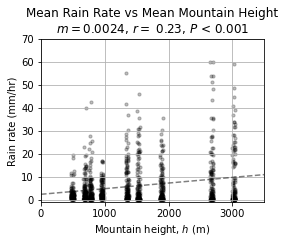

3.954669093523142e-15


In [6]:
plt.clf()
plt.close('all')

conds = (df.lfhr>=-24) & (df.lfhr<=24)
# conds = (df.tclon>=120) & (df.tclon<=122) & (df.tclat>=15) & (df.tclat<=16)
cconds = conds

h_all = np.abs(np.concatenate((df[cconds].h_1,df[conds].h_2, df[cconds].h_3)))
rr_all = np.concatenate((df[cconds].rr_1,df[conds].rr_2,df[cconds].rr_3))

slope, intercept, r_value, p_value, std_err = sps.linregress(h_all.astype(float), rr_all.astype(float))
x = np.linspace(0,4000,100)
# y_i = 1*x + 0
y = slope*x +intercept

fig = plt.figure(figsize=(4,3),
                          facecolor='white')  
ax1 = fig.add_subplot(111, facecolor='white')

h_all_j = h_all + 50 * np.random.rand(len(h_all)) -0.05

# ax1.scatter(h_all, rr_all, color='k', alpha=0.5)
ax1.scatter(h_all_j, rr_all, color='k', alpha=0.25, s=10)
ax1.plot(x,y, '--k', alpha=0.5)


ax1.set_ylabel(r'Rain rate (mm/hr)')
ax1.set_xlabel('Mountain height, $h$ (m)')
ax1.set_xlim(-1,3500)
ax1.set_ylim(-1,70)
ax1.grid()

ax1.set_title('Mean Rain Rate vs Mean Mountain Height\n'+
              '$m =$' + '%.4f'%slope+
              ', $r =$ ' + '%.2f'% r_value + ', $P$ < 0.001')

# plt.legend(loc='upper left', fontsize='large')
plt.savefig(os.path.join(path_out, 'rr_vs_h_all_jitter.png'), bbox_inches='tight', dpi=300)

plt.show()
print(p_value)

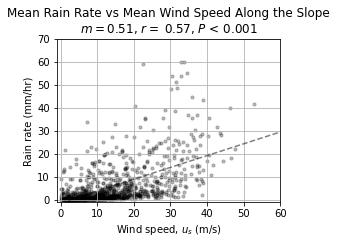

7.9139293798242e-89


In [7]:
plt.clf()
plt.close('all')


# conds = (df.tclon>=120) & (df.tclon<=122) & (df.tclat>=15) & (df.tclat<=16)
cconds = conds

u = (np.concatenate((df[cconds].u_1,df[cconds].u_2, df[cconds].u_3)))
u_all = u[u<=0.]*-1

rr = np.concatenate((df[cconds].rr_1,df[cconds].rr_2,df[cconds].rr_3))
rr_all = rr[u<=0.]

# rr_all = np.concatenate((df[cconds].rr_1,df[cconds].rr_2,df[cconds].rr_3))

slope, intercept, r_value, p_value, std_err = sps.linregress(u_all.astype(float), rr_all.astype(float))
x = np.linspace(0,70,100)
# y_i = 1*x + 0
y = slope*x +intercept

fig = plt.figure(figsize=(4,3),
                          facecolor='white')  
ax1 = fig.add_subplot(111, facecolor='white')

# h_all_j = h_all + 50 * np.random.rand(len(h_all)) -0.05

# ax1.scatter(h_all, rr_all, color='k', alpha=0.5)
ax1.scatter(u_all, rr_all, color='k', alpha=0.25, s=10)
ax1.plot(x,y, '--k', alpha=0.5)


ax1.set_ylabel(r'Rain rate (mm/hr)')
ax1.set_xlabel(r'Wind speed, $u_s$ (m/s)')

ax1.set_xlim(-1,60)
ax1.set_ylim(-1,70)
ax1.grid()

# ax1.set_title('Mean Precipitation Rate vs Mountain Height\n')
ax1.set_title('Mean Rain Rate vs '+r'Mean Wind Speed Along the Slope'+'\n' +
              '$m =$' + '%.2f'%slope+
              ', $r =$ ' + '%.2f'% r_value + ', $P$ < 0.001')

# plt.legend(loc='upper left', fontsize='large')
plt.savefig(os.path.join(path_out, 'rr_vs_u_all.png'), bbox_inches='tight', dpi=300)

plt.show()
print(p_value)

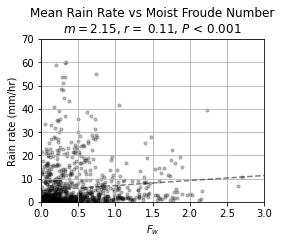

0.0009303514993383759


In [11]:
plt.clf()
plt.close('all')

# conds = (df.lfhr>=-24) & (df.lfhr<=24)
# conds = (df.tclon>=120) & (df.tclon<=122) & (df.tclat>=15) & (df.tclat<=16)
cconds = conds

u = (np.concatenate((df[cconds].u_1,df[cconds].u_2, df[cconds].u_3)))
u_all = u[u<=0.]*-1
fw = (np.concatenate((df[cconds].Fw_1,df[cconds].Fw_2, df[cconds].Fw_3)))
fw_all = fw[u<=0.]*-1
rr = np.concatenate((df[cconds].rr_1,df[cconds].rr_2,df[cconds].rr_3))
rr_all = rr[u<=0.]

fw_all_new = fw_all.astype(float)[~np.isnan(fw_all.astype(float))]
rr_all_new = rr_all.astype(float)[~np.isnan(fw_all.astype(float))]

slope, intercept, r_value, p_value, std_err = sps.linregress(fw_all_new, rr_all_new)
x = np.linspace(0,3,100)
# y_i = 1*x + 0
y = slope*x +intercept

fig = plt.figure(figsize=(4,3),
                          facecolor='white')  
ax1 = fig.add_subplot(111, facecolor='white')

# h_all_j = h_all + 50 * np.random.rand(len(h_all)) -0.05

# ax1.scatter(h_all, rr_all, color='k', alpha=0.5)
ax1.scatter(fw_all, rr_all, color='k', alpha=0.25, s=10)
ax1.plot(x,y, '--k', alpha=0.5)


ax1.set_ylabel(r'Rain rate (mm/hr)')
ax1.set_xlabel(r'$F_w$')

ax1.set_xlim(0,3)
ax1.set_ylim(0,70)
ax1.grid()

# ax1.set_title('Mean Precipitation Rate vs Mountain Height\n')
ax1.set_title('Mean Rain Rate vs '+r'Moist Froude Number'+'\n' +
              '$m =$' + '%.2f'%slope+
              ', $r =$ ' + '%.2f'% r_value + ', $P$ < 0.001')

# plt.legend(loc='upper left', fontsize='large')
plt.savefig(os.path.join(path_out, 'rr_vs_fw_all.png'), bbox_inches='tight', dpi=300)

plt.show()
print(p_value)

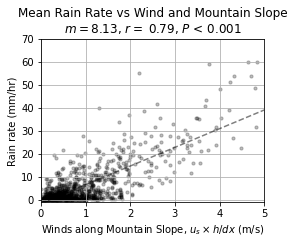

3.1638450945831496e-220


In [10]:
plt.clf()
plt.close('all')
dx = 27.75*1000

conds = (df.lfhr>=-24) & (df.lfhr<=24)
# conds = (df.tclon>=120) & (df.tclon<=122) & (df.tclat>=15) & (df.tclat<=16)
cconds = conds

# u_all = np.abs(np.concatenate((df[cconds].u_1,df[cconds].u_2, df[cconds].u_3))*np.concatenate((df[cconds].h_1,df[cconds].h_2, df[cconds].h_3)))/dx
u = (np.concatenate((df[cconds].u_1_mnt,df[cconds].u_2_mnt, df[cconds].u_3_mnt))*np.concatenate((df[cconds].h_1,df[cconds].h_2, df[cconds].h_3)))/dx
u_all = u[u<=0.]*-1

rr = np.concatenate((df[cconds].rr_1,df[cconds].rr_2,df[cconds].rr_3))
rr_all = rr[u<=0.]

slope, intercept, r_value, p_value, std_err = sps.linregress(u_all.astype(float), rr_all.astype(float))
# x = np.linspace(0,2,100)
x = np.linspace(-0.5,5,100)
# y_i = 1*x + 0
y = slope*x +intercept

fig = plt.figure(figsize=(4,3),
                          facecolor='white')  
ax1 = fig.add_subplot(111, facecolor='white')

# h_all_j = h_all + 50 * np.random.rand(len(h_all)) -0.05

# ax1.scatter(h_all, rr_all, color='k', alpha=0.5)
ax1.scatter(u_all, rr_all, color='k', alpha=0.25, s=10)
ax1.plot(x,y, '--k', alpha=0.5)


ax1.set_ylabel(r'Rain rate (mm/hr)')
ax1.set_xlabel(r'Winds along Mountain Slope, $u_s\times h/dx$ (m/s)')

ax1.set_xlim(0,5)
ax1.set_ylim(-1,70)
ax1.grid()

# ax1.set_title('Mean Precipitation Rate vs Mountain Height\n')
ax1.set_title('Mean Rain Rate vs '+r'Wind and Mountain Slope'+'\n' +
              '$m =$' + '%.2f'%slope+
              ', $r =$ ' + '%.2f'% r_value + ', $P$ < 0.001')

# plt.legend(loc='upper left', fontsize='large')
plt.savefig(os.path.join(path_out, 'rr_vs_hdz_allmnt.png'), bbox_inches='tight', dpi=300)

plt.show()
print(p_value)